In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import HTML,display
import PIL 
from PIL import Image
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        
        # Crop the skip tensor to match upsampled tensor's size
        _, _, h, w = x.shape
        skip = skip[:, :, :h, :w]
        
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(1, 64)   # Assuming grayscale input
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        
        # Bridge
        self.b = conv_block(512, 1024)
        
        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        
        # Final Output
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        
    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        b = self.b(p4)
        
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        outputs = self.outputs(d4)
        return outputs

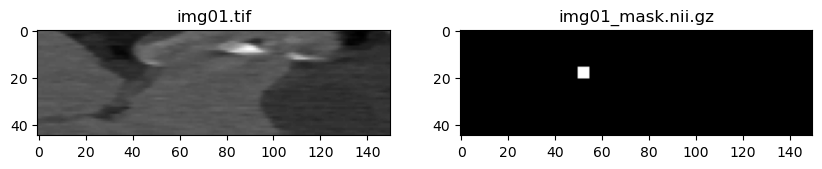

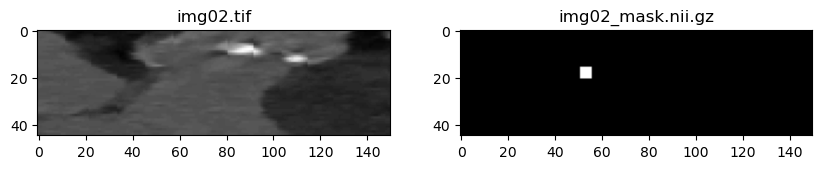

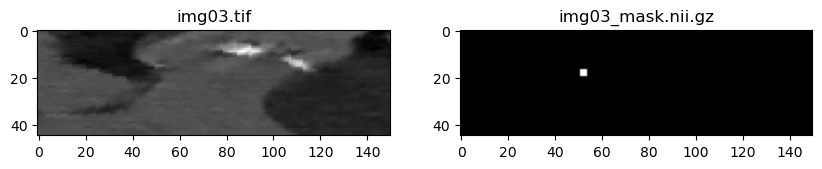

In [3]:
import matplotlib.pyplot as plt

# Paths
image_dir = "/Users/owner/Desktop/AI NYU Langone/raw2/Images"
mask_dir = "/Users/owner/Desktop/AI NYU Langone/raw2/Masks"

# Lists of image and mask paths
image_data_path_list = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])[:27]
mask_data_path_list = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii.gz')])[:27]


import os
import matplotlib.pyplot as plt

# Adjusted AortaDataset class
class AortaDataset():
    def __init__(self, images_list, masks_list, transform=None):
        self.images = images_list
        self.masks = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]
        
        image = Image.open(image_path).convert("L")
        mask = nib.load(mask_path).get_fdata()
        # Convert PIL Image to numpy array
        image = np.array(image)
        # Add channel dimension (making it 1 x height x width)
        image = np.expand_dims(image, axis=0)
        # Convert numpy arrays to PyTorch tensors
        image = torch.from_numpy(image).float()
        
        # Apply the transformations to the mask
        mask = np.rot90(mask)
        mask = np.flipud(mask)
        mask = torch.from_numpy(mask).float()
        mask = mask.permute(2, 0, 1)

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask, image_path, mask_path

# Instantiate the dataset using the truncated lists
dataset = AortaDataset(images_list=image_data_path_list, masks_list=mask_data_path_list)

# Load and visualize the samples
for i in range(3):
    image, mask, image_path, mask_path = dataset[i]
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image.squeeze(), cmap = "gray")
    ax[0].set_title(os.path.basename(image_path))
    ax[1].imshow(mask.squeeze(), cmap = "gray")
    ax[1].set_title(os.path.basename(mask_path))
    plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the UNet model
model = UNet()
model = model.to(device)  # Move model to GPU if available


# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy with logits is commonly used for binary segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training (and optionally validation)
train_dataset = AortaDataset(images_list=image_data_path_list, masks_list=mask_data_path_list)  # You can also apply transformations if needed
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [5]:
def dice_coefficient(predicted, target):
    # Flatten the tensors
    predicted = predicted.view(-1)
    target = target.view(-1)
    
    intersection = (predicted * target).sum()
    return (2. * intersection) / (predicted.sum() + target.sum())

In [12]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    epoch_dice = 0

    for batch in train_loader:
        images, masks, image_path, mask_path = batch
        images, masks = images.to(device), masks.to(device)  # Move data to GPU if available
        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=(45, 150), mode='bilinear', align_corners=True)

        # Compute the loss
        loss = criterion(outputs, masks)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate Dice Coefficient
        with torch.no_grad():
            predicted = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            predicted = (predicted > 0.5).float()  # Binarize the output
            dice_val = dice_coefficient(predicted, masks)
            epoch_dice += dice_val.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}, Dice Coefficient: {epoch_dice/len(train_loader)}")

Epoch 1/100, Loss: 0.018002555705606937, Dice Coefficient: 0.7687782943248749
Epoch 2/100, Loss: 0.017672489397227764, Dice Coefficient: 0.8077890574932098
Epoch 3/100, Loss: 0.017299638129770756, Dice Coefficient: 0.8229033648967743
Epoch 4/100, Loss: 0.01692386996001005, Dice Coefficient: 0.8257350027561188
Epoch 5/100, Loss: 0.016791963949799538, Dice Coefficient: 0.8586237132549286
Epoch 6/100, Loss: 0.01640510745346546, Dice Coefficient: 0.8043769598007202
Epoch 7/100, Loss: 0.01611035130918026, Dice Coefficient: 0.8619793653488159
Epoch 8/100, Loss: 0.015769539400935173, Dice Coefficient: 0.8644224107265472
Epoch 9/100, Loss: 0.015585987363010645, Dice Coefficient: 0.8582383990287781
Epoch 10/100, Loss: 0.015248946379870176, Dice Coefficient: 0.8699695765972137
Epoch 11/100, Loss: 0.01504112035036087, Dice Coefficient: 0.8703415095806122
Epoch 12/100, Loss: 0.01478734239935875, Dice Coefficient: 0.9010818898677826
Epoch 13/100, Loss: 0.014588608406484127, Dice Coefficient: 0.8370

In [7]:
image, mask, image_path, mask_path = dataset[10]  # Fetching the first image-mask pair for demonstration
print("Image shape:", np.array(image).shape)
print("Mask shape:", np.array(mask).shape)

Image shape: (1, 45, 150)
Mask shape: (1, 45, 150)


In [9]:
from skimage.transform import resize

def overlay_grayscale_mask_on_image(image, mask, color=(255, 0, 0)):
    """
    Overlay the grayscale mask on the grayscale image.
    :param image: The original grayscale image.
    :param mask: The grayscale mask.
    :param color: RGB color for mask overlay. Default is red.
    :return: The image with mask overlaid.
    """
    
    mask_np = np.array(mask).squeeze()
    
    # Resize the mask to match the image dimensions
    mask_np = resize(mask_np, (45, 150))
    image_np = np.array(image).squeeze()
    # Normalize the image values to [0, 1] range
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    # Convert grayscale image to RGB
    image_rgb = np.stack([image_np]*3, axis=-1) * 255.0  # Scale to [0, 255]
    print("Max mask value:", mask_np.max())
    print("Min mask value:", mask_np.min())

    # Overlay the mask on each channel of the image
    for i in range(3):
        image_rgb[:,:,i] = np.where(mask_np > 0.1, color[i], image_rgb[:,:,i])
    
    return image_rgb

# Let's visualize an example
#overlay = overlay_grayscale_mask_on_image(image, mask)
#plt.imshow(overlay.astype(np.uint8))
#plt.axis('off')
#plt.show()

torch.Size([1, 1, 45, 150])
Max mask value: 7.5041203
Min mask value: -8.541299


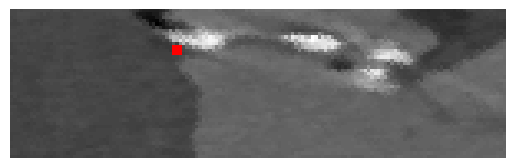

In [32]:
def preprocess_image(image_path):    
    # Load the image
    image = Image.open(image_path).convert("L")
    image = image.resize((150, 45), Image.ANTIALIAS)
    # Convert PIL Image to numpy array
    image = np.array(image)
     # Add channel dimension (making it 1 x height x width)
    image = np.expand_dims(image, axis=0)
    # Convert numpy arrays to PyTorch tensors
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(1)
    print(image_tensor.shape)
    return image_tensor

def postprocess_output(output_tensor):
    return output_tensor.detach().numpy().squeeze()

# Process a new image
image_path = "/Users/owner/Desktop/AI NYU Langone/Raw2/images/img27.tif"
image_tensor = preprocess_image(image_path)

# Pass the image through the U-Net
with torch.no_grad():
    mask = model(image_tensor)

# Convert the mask to numpy for visualization
mask_np = postprocess_output(mask)

# Overlay the mask on the original image
overlay = overlay_grayscale_mask_on_image(image_tensor.squeeze(), mask_np)

# Display the result
plt.imshow(overlay.astype(np.uint8))
plt.axis('off')
plt.show()